In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas as gpd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.utils import np_utils
import keras_tuner as kt

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [4]:
# Load some data
ef = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")

In [5]:
df = ef.copy()
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
df.describe(include="all")

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,1296675,1.296675e+06,1296675,1296675,1.296675e+06,1296675,1296675,1296675,1296675,1296675,...,1.296675e+06,1.296675e+06,1.296675e+06,1296675,1296675,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
unique,1274791,NaN,693,14,NaN,352,481,2,983,894,...,NaN,NaN,NaN,494,968,1296675,NaN,NaN,NaN,NaN
top,2019-04-22 16:02:01,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,0069 Robin Brooks Apt. 695,Birmingham,...,NaN,NaN,NaN,Film/video editor,1977-03-23,0b242abb623afc578575680df30655b9,NaN,NaN,NaN,NaN
freq,4,NaN,4403,131659,NaN,26669,28794,709863,3123,5617,...,NaN,NaN,NaN,9779,5636,1,NaN,NaN,NaN,NaN
mean,NaN,4.171920e+17,NaN,NaN,7.035104e+01,NaN,NaN,NaN,NaN,NaN,...,3.853762e+01,-9.022634e+01,8.882444e+04,NaN,NaN,NaN,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,NaN,1.308806e+18,NaN,NaN,1.603160e+02,NaN,NaN,NaN,NaN,NaN,...,5.075808e+00,1.375908e+01,3.019564e+05,NaN,NaN,NaN,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,NaN,6.041621e+10,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,...,2.002710e+01,-1.656723e+02,2.300000e+01,NaN,NaN,NaN,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,NaN,1.800429e+14,NaN,NaN,9.650000e+00,NaN,NaN,NaN,NaN,NaN,...,3.462050e+01,-9.679800e+01,7.430000e+02,NaN,NaN,NaN,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,NaN,3.521417e+15,NaN,NaN,4.752000e+01,NaN,NaN,NaN,NaN,NaN,...,3.935430e+01,-8.747690e+01,2.456000e+03,NaN,NaN,NaN,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,NaN,4.642255e+15,NaN,NaN,8.314000e+01,NaN,NaN,NaN,NaN,NaN,...,4.194040e+01,-8.015800e+01,2.032800e+04,NaN,NaN,NaN,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want. 

In [8]:
latlong = gpd.GeoDataFrame(df[['lat','long']], geometry=gpd.points_from_xy(df['lat'], df['long']))
merchlatlong = gpd.GeoDataFrame(df[['merch_lat','merch_long']], geometry=gpd.points_from_xy(df['merch_lat'], df['merch_long']))
df['distance'] = latlong['geometry'].distance(merchlatlong['geometry'],align=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.872830
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.272310
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.975845
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.919802
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.868505


### Deal with Time

Can we make date/time and the date of birth into something useful?

In [9]:
df['trans_date_trans_time'] = df['trans_date_trans_time'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
df['dob'] = df['dob'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
df['age'] = df['trans_date_trans_time'] - df['dob']

In [10]:
df['age'] = df['age'].apply(lambda x: x.days//365)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.872830,30
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.272310,40
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.975845,56
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.919802,52
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.868505,32


### Check Target Balance

In [11]:
neg, pos = np.bincount(df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



### Prepare Data


In [12]:
df.pop('trans_date_trans_time')
df.pop('dob')
df.pop('job')
df.pop('trans_num')
df.pop('merchant')
df.pop('first')
df.pop('last')
df.pop('gender')
df.pop('street')
df.pop('city')
df.pop('state')
df = pd.get_dummies(df, drop_first=True)
df.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,...,0,0,0,0,1,0,0,0,0,0
1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,...,1,0,0,0,0,0,0,0,0,0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,...,0,0,0,0,0,0,0,0,0,0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,...,0,0,0,0,0,0,0,0,0,0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,...,0,0,0,0,0,1,0,0,0,0


### Split Data

In [13]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('is_fraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('is_fraud'))
test_labels = np.array(test_df.pop('is_fraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

scale = StandardScaler()
train_features = scale.fit_transform(train_features)
val_features = scale.fit_transform(val_features)
test_features = scale.fit_transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (829872,)
Validation labels shape: (207468,)
Test labels shape: (259335,)
Training features shape: (829872, 24)
Validation features shape: (207468, 24)
Test features shape: (259335, 24)


### Model

In [42]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(120, activation='relu',input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(120, activation='relu',),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(60, activation='relu'),
        keras.layers.Dense(60, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [43]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


In [44]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model(metrics=METRICS, output_bias=np.log(pos/neg))
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 120)               3000      
                                                                 
 dense_21 (Dense)            (None, 120)               14520     
                                                                 
 dropout_8 (Dropout)         (None, 120)               0         
                                                                 
 dense_22 (Dense)            (None, 60)                7260      
                                                                 
 dense_23 (Dense)            (None, 60)                3660      
                                                                 
 dropout_9 (Dropout)         (None, 60)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                

In [45]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 1.0)
weight_for_1 = (1 / pos) * (total / 1.7)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.01
Weight for class 1: 101.62


In [46]:
#class weights 0:1, 1:10
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)


Epoch 1/100
406/406 [==============================] - 6s 9ms/step - loss: 0.6120 - tp: 3413.0000 - fp: 38285.0000 - tn: 786731.0000 - fn: 1443.0000 - accuracy: 0.9521 - precision: 0.0819 - recall: 0.7028 - auc: 0.8955 - prc: 0.2357 - val_loss: 0.1724 - val_tp: 944.0000 - val_fp: 4144.0000 - val_tn: 202103.0000 - val_fn: 277.0000 - val_accuracy: 0.9787 - val_precision: 0.1855 - val_recall: 0.7731 - val_auc: 0.9574 - val_prc: 0.3753
Epoch 2/100
406/406 [==============================] - 3s 7ms/step - loss: 0.3597 - tp: 3980.0000 - fp: 26801.0000 - tn: 798215.0000 - fn: 876.0000 - accuracy: 0.9666 - precision: 0.1293 - recall: 0.8196 - auc: 0.9639 - prc: 0.3637 - val_loss: 0.1249 - val_tp: 1077.0000 - val_fp: 6025.0000 - val_tn: 200222.0000 - val_fn: 144.0000 - val_accuracy: 0.9703 - val_precision: 0.1516 - val_recall: 0.8821 - val_auc: 0.9803 - val_prc: 0.5095
Epoch 3/100
406/406 [==============================] - 3s 7ms/step - loss: 0.2758 - tp: 4201.0000 - fp: 24779.0000 - tn: 800237.

In [47]:
#train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(test_features, test_labels,batch_size=BATCH_SIZE, verbose=0)
#results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)

127/127 [==============================] - 0s 2ms/step


loss :  0.05225934460759163
tp :  1290.0
fp :  3919.0
tn :  253987.0
fn :  139.0
accuracy :  0.9843522906303406
precision :  0.24764829874038696
recall :  0.9027291536331177
auc :  0.989843487739563
prc :  0.7357036471366882
Legitimate Transactions Detected (True Negatives):  253987
Legitimate Transactions Incorrectly Detected (False Positives):  3919
Fraudulent Transactions Missed (False Negatives):  139
Fraudulent Transactions Detected (True Positives):  1290
Total Fraudulent Transactions:  1429


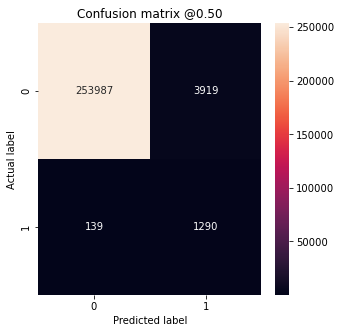

In [48]:
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
plot_cm(test_labels, test_predictions_baseline)

In [49]:
model.save('FraudModel')

INFO:tensorflow:Assets written to: FraudModel\assets
